In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Input, Bidirectional
from keras.layers import LSTM, Embedding
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy

In [259]:
def build_sentence(filename):
    """
    Reads a file containing tagged words and constructs a list of sentences.

    Each line in the file should contain words with their respective tags,
    separated by underscores (e.g., "word_tag"). The function splits each
    line into words, separates the words from their tags, and constructs
    a list of sentences where each sentence is a list of (word, tag) tuples.

    Args:
        filename (str): The name of the file to read from. The file should
                        be located in the "data/" directory.

    Returns:
        tuple: A tuple containing two lists:
           - The first list contains sentences, where each sentence is a list of words.
           - The second list contains sentences, where each sentence is a list of tags.
    """
    path = "data/"
    words, tags = [], []
    with open(path + filename, "r") as f:

        corpus = f.readlines()
        for sentence in corpus:
            words_sent, tags_sent = [], []

            for token in sentence.split():
                token = token.split(sep="_")
                words_sent.append(token[0])
                tags_sent.append(token[1])

            words.append(words_sent)
            tags.append(tags_sent)

    return words, tags

In [260]:
X_val, y_val = build_sentence("macmorpho-dev.txt")
X_test, y_test = build_sentence("macmorpho-test.txt")
X_train, y_train = build_sentence("macmorpho-train.txt")

print(f"Train sentences: {len(X_train)}")
print(f"Test sentences: {len(X_test)}")
print(f"Valid sentences: {len(X_val)}")

Train sentences: 37948
Test sentences: 9987
Valid sentences: 1997


In [261]:
maxlen_train = max(len(sent) for sent in X_train)
maxlen_test = max(len(sent) for sent in X_test)
maxlen_val = max(len(sent) for sent in X_val)

MAX_SEQUENCE_LENGTH = max((maxlen_train, maxlen_test, maxlen_val))
MAX_SEQUENCE_LENGTH

248

In [262]:
word_tokenizer = Tokenizer(
    num_words=None,
    lower=False,
    oov_token="UNK",
    filters='#$%&*+-/<=>@[\\]^_`{|}~\t\n',
)

word_tokenizer.fit_on_texts(X_train)
X_train_int = word_tokenizer.texts_to_sequences(X_train)
X_test_int = word_tokenizer.texts_to_sequences(X_test)
X_val_int = word_tokenizer.texts_to_sequences(X_val)

In [263]:
len(X_train_int), len(X_test_int), len(X_val_int)

(37948, 9987, 1997)

In [264]:
word2index = word_tokenizer.word_index
VOCAB_SIZE = len(word2index)
print(f"Found {VOCAB_SIZE} unique words")

Found 52760 unique words


In [265]:
word2index

{'UNK': 1,
 ',': 2,
 '.': 3,
 'de': 4,
 'a': 5,
 'o': 6,
 'e': 7,
 '"': 8,
 'que': 9,
 'do': 10,
 'da': 11,
 'em': 12,
 'para': 13,
 'com': 14,
 'no': 15,
 'um': 16,
 ')': 17,
 '(': 18,
 'O': 19,
 'é': 20,
 'os': 21,
 'na': 22,
 'A': 23,
 'uma': 24,
 'não': 25,
 'dos': 26,
 'por': 27,
 'se': 28,
 'as': 29,
 'ao': 30,
 'mais': 31,
 '-': 32,
 '%': 33,
 'foi': 34,
 'das': 35,
 'como': 36,
 'à': 37,
 ':': 38,
 'ser': 39,
 'pela': 40,
 'Os': 41,
 'pelo': 42,
 'São': 43,
 'sua': 44,
 'ou': 45,
 'Paulo': 46,
 'seu': 47,
 'está': 48,
 'nos': 49,
 'sobre': 50,
 'US$': 51,
 'entre': 52,
 'tem': 53,
 'também': 54,
 'são': 55,
 'até': 56,
 'disse': 57,
 'anos': 58,
 'mas': 59,
 'ano': 60,
 'Brasil': 61,
 'ele': 62,
 '-se': 63,
 'já': 64,
 'dia': 65,
 'diz': 66,
 'Em': 67,
 'ontem': 68,
 'pode': 69,
 'governo': 70,
 'vai': 71,
 'No': 72,
 'Segundo': 73,
 'hoje': 74,
 'às': 75,
 '?': 76,
 'ainda': 77,
 'dois': 78,
 'há': 79,
 'mil': 80,
 'As': 81,
 'ter': 82,
 'milhões': 83,
 'Para': 84,
 'foram': 8

In [266]:
def flatten(list_of_lists):
    flattened = [val for sublist in list_of_lists for val in sublist]
    return flattened


all_targets_train = {x for l in y_train for x in l}
all_targets_test = {x for l in y_test for x in l}
all_targets_val = {x for l in y_val for x in l}

In [267]:
all_targets_train

{'ADJ',
 'ADV',
 'ADV-KS',
 'ART',
 'CUR',
 'IN',
 'KC',
 'KS',
 'N',
 'NPROP',
 'NUM',
 'PCP',
 'PDEN',
 'PREP',
 'PREP+ADV',
 'PREP+ART',
 'PREP+PRO-KS',
 'PREP+PROADJ',
 'PREP+PROPESS',
 'PREP+PROSUB',
 'PRO-KS',
 'PROADJ',
 'PROPESS',
 'PROSUB',
 'PU',
 'V'}

In [268]:
len(all_targets_test), len(all_targets_test), len(all_targets_val)

(26, 26, 26)

In [269]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y_train)
y_train_int = tag_tokenizer.texts_to_sequences(y_train)
y_test_int = tag_tokenizer.texts_to_sequences(y_test)
y_val_int = tag_tokenizer.texts_to_sequences(y_val)

y_train_int_unpadded = y_train_int
y_test_int_unpadded = y_test_int
y_val_int_unpadded = y_val_int

In [270]:
len(y_test_int_unpadded), len(y_train_int_unpadded), len(y_val_int_unpadded)

(9987, 37948, 1997)

In [271]:
X_train_int = pad_sequences(X_train_int, maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of data train tensor:", X_train_int.shape)
X_test_int = pad_sequences(X_test_int, maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of data test tensor:", X_test_int.shape)
X_val_int = pad_sequences(X_val_int, maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of data val tensor:", X_val_int.shape)

y_train_int = pad_sequences(y_train_int, maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of train output tensor:", y_train_int.shape)
y_test_int = pad_sequences(y_test_int, maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of test output tensor:", y_test_int.shape)
y_val_int = pad_sequences(y_val_int, maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of val output tensor:", y_val_int.shape)

Shape of data train tensor: (37948, 248)
Shape of data test tensor: (9987, 248)
Shape of data val tensor: (1997, 248)
Shape of train output tensor: (37948, 248)
Shape of test output tensor: (9987, 248)
Shape of val output tensor: (1997, 248)


In [272]:
NUM_CLASSES = len(all_targets_train) + 1
NUM_CLASSES

27

In [287]:
def build_model(
    input_dim,
    vocab_size,
    embedding_dim,
    lstm_units,
    num_classes,
    recurrent_dropout=0.01,
):
    i = Input(shape=(input_dim,))
    x = Embedding(vocab_size + 1, embedding_dim)(i)
    x = Bidirectional(
        LSTM(
            lstm_units,
            return_sequences=True,
            recurrent_dropout=recurrent_dropout,
        )
    )(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = Model(i, x)
    model.compile(
        loss=SparseCategoricalCrossentropy(),
        optimizer="adam",
        metrics=["accuracy"],
    )
    model.summary()
    return model

In [290]:
EMBEDDING_DIM = 32
LSTM_UNITS = 32

model = build_model(MAX_SEQUENCE_LENGTH, VOCAB_SIZE, EMBEDDING_DIM, LSTM_UNITS, NUM_CLASSES)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 248)]             0         
                                                                 
 embedding_10 (Embedding)    (None, 248, 32)           1688352   
                                                                 
 bidirectional_10 (Bidirecti  (None, 248, 64)          16640     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 248, 27)           1755      
                                                                 
Total params: 1,706,747
Trainable params: 1,706,747
Non-trainable params: 0
_________________________________________________________________


In [291]:
r = model.fit(
    X_train_int,
    y_train_int,
    epochs=5,
    validation_data=(X_val_int, y_val_int),
    verbose=True,
)

Epoch 1/5
1186/1186 [==============================] - 288s 239ms/step - loss: 0.2303 - accuracy: 0.9488 - val_loss: 0.0711 - val_accuracy: 0.9810
Epoch 2/5
1186/1186 [==============================] - 284s 240ms/step - loss: 0.0359 - accuracy: 0.9914 - val_loss: 0.0223 - val_accuracy: 0.9942
Epoch 3/5
1186/1186 [==============================] - 283s 239ms/step - loss: 0.0143 - accuracy: 0.9963 - val_loss: 0.0160 - val_accuracy: 0.9955
Epoch 4/5
1186/1186 [==============================] - 287s 242ms/step - loss: 0.0093 - accuracy: 0.9975 - val_loss: 0.0143 - val_accuracy: 0.9959
Epoch 5/5
1186/1186 [==============================] - 285s 240ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.0134 - val_accuracy: 0.9962


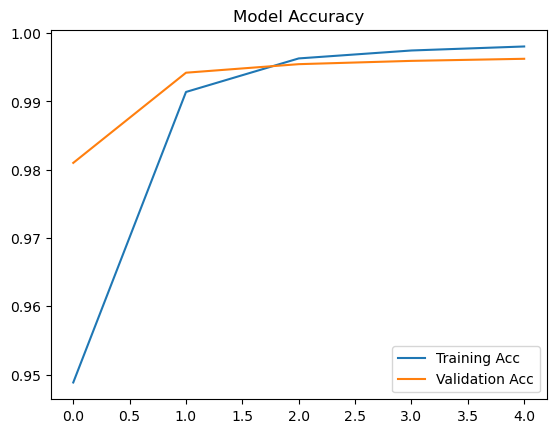

In [292]:
plt.plot(r.history["accuracy"], label="Training Acc")
plt.plot(r.history["val_accuracy"], label="Validation Acc")
plt.title("Model Accuracy")
plt.legend()

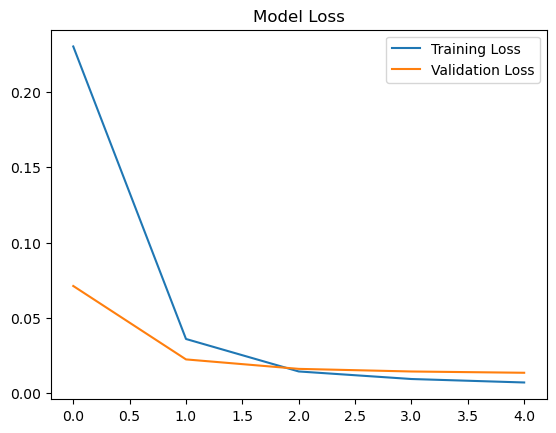

In [293]:
plt.plot(r.history["loss"], label="Training Loss")
plt.plot(r.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.legend()

In [294]:
train_lengths = []
for sentence in X_train:
    train_lengths.append(len(sentence))

test_lengths = []
for sentence in X_test:
    test_lengths.append(len(sentence))

In [295]:
train_probs = model.predict(X_train_int)  # N x T x K
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
    # probs is T x K
    probs_ = probs[-length:]
    preds = np.argmax(probs_, axis=1)
    train_predictions.append(preds)

# flatten
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(y_train_int_unpadded)

1186/1186 [==============================] - 63s 53ms/step


In [296]:
test_probs = model.predict(X_test_int)  # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
    # probs is T x K
    probs_ = probs[-length:]
    preds = np.argmax(probs_, axis=1)
    test_predictions.append(preds)

# flatten
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(y_test_int_unpadded)

313/313 [==============================] - 16s 52ms/step


In [297]:
from sklearn.metrics import accuracy_score, f1_score

print(
    "Train acc:",
    accuracy_score(
        flat_train_targets,
        flat_train_predictions,
    ),
)
print(
    "Test acc:",
    accuracy_score(
        flat_test_targets,
        flat_test_predictions,
    ),
)

print(
    "Train f1:",
    f1_score(
        flat_train_targets,
        flat_train_predictions,
        average="macro",
    ),
)
print(
    "Test f1:",
    f1_score(
        flat_test_targets,
        flat_test_predictions,
        average="macro",
    ),
)

Train acc: 0.9801330684958208
Test acc: 0.9373111401389224
Train f1: 0.7937640252468593
Test f1: 0.7548510612922891


In [298]:
test_text = [
    "É deitado em uma bela rede que Dorival Caymmi surge como cover boy o novo comercial do Itaú .",
    "Caymmi deixou escapar nos bastidores que não gostava muito de rede .",
    "Mas que fazia bem para o marketing da preguiça .",
    "Que faz bem para seu bolso .",
]

texts_as_ints = word_tokenizer.texts_to_sequences(test_text)
texts_as_ints = pad_sequences(texts_as_ints, maxlen=MAX_SEQUENCE_LENGTH)
probs = model.predict(np.asarray(texts_as_ints))

1/1 [==============================] - 0s 58ms/step


In [299]:
outputs = []

for i in range(len(texts_as_ints)):
    sentOutput = []
    for j, prob in enumerate(probs[i]):
        tag = tag_tokenizer.index_word.get(np.argmax(prob), 'UNK')
        id = texts_as_ints[i][j]
        if id != 0:
            sentOutput.append(( word_tokenizer.index_word[id], tag))
    outputs.append(sentOutput)

for output in outputs:
    print(output)

[('É', 'v'), ('deitado', 'pcp'), ('em', 'prep'), ('uma', 'art'), ('bela', 'adj'), ('rede', 'n'), ('que', 'pro-ks'), ('Dorival', 'nprop'), ('Caymmi', 'nprop'), ('surge', 'v'), ('como', 'prep'), ('UNK', 'n'), ('UNK', 'v'), ('o', 'art'), ('novo', 'adj'), ('comercial', 'adj'), ('do', 'prep+art'), ('Itaú', 'nprop'), ('.', 'pu')]
[('Caymmi', 'nprop'), ('deixou', 'v'), ('escapar', 'v'), ('nos', 'prep+art'), ('bastidores', 'n'), ('que', 'pro-ks'), ('não', 'adv'), ('gostava', 'v'), ('muito', 'adv'), ('de', 'prep'), ('rede', 'n'), ('.', 'pu')]
[('Mas', 'kc'), ('que', 'pro-ks'), ('fazia', 'v'), ('bem', 'adv'), ('para', 'prep'), ('o', 'art'), ('marketing', 'n'), ('da', 'prep+art'), ('preguiça', 'n'), ('.', 'pu')]
[('Que', 'prosub'), ('faz', 'v'), ('bem', 'adv'), ('para', 'prep'), ('seu', 'proadj'), ('bolso', 'n'), ('.', 'pu')]
